In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import functools 
import datetime

import pmana.utils

In [2]:
TIME_DIR = "20251124"
TIME_RANGE = "20251124_20251127"

#### Parse Padova test-stand data

In [3]:
PATH_INPUT  = f"/Users/triozzi/Downloads/Test_{TIME_RANGE}"
PATH_TARGET = f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}"

pmana.utils.io.FormatPadovaData(
    PATH_INPUT,  ###< raw Padova test-stand campaign
    PATH_TARGET  ###< target path for the restructured data
)

Skipping unrecognized file: TemperatureLog_20251124_.txt
Skipping unrecognized file: TestCondition.txt.txt


#### Look at one single measurement

There were 3 used channels in this campaign.


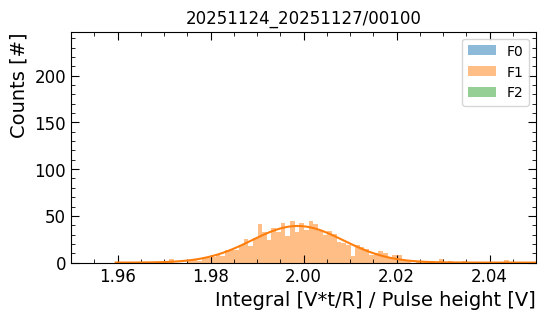

In [11]:
fig, ax = plt.subplots(figsize=(6,3))

MEASUREMENT = '00100'
# extract a measurement 
Data = pmana.utils.io.ExtractSingleMeasurement(
    f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}/{MEASUREMENT}"
)
print(f"There were {len(Data)} used channels in this measurement.")

CHs = [1, 2, 3]
for i, chname in enumerate(CHs):
    # plot channel data
    pmana.utils.plotting.PlotSingleChannel(
        Data[i],
        ax,
        channel = i,
        rebin = False
    )

ax = pmana.utils.plotting.UpdateMatplotlibStyle(
    ax,
    "Integral [V*t/R] / Pulse height [V]",
    "Counts [#]"
)

ax.legend()
ax.set_title(f"{TIME_RANGE}/{MEASUREMENT}")
ax.set_xlim(1.95, 2.05)
# ax.set_xlim(0.0312, 0.0317)
plt.show()

#### Analyze a campaign

In [3]:
PATH_CAMPAIGN = f"../data/{TIME_DIR}/DataPadova_{TIME_RANGE}"
PATH_TEMPERATURES = f"../data/{TIME_DIR}/PM_Temperature_{TIME_RANGE}.txt"
PATH_TIMES = f"../data/{TIME_DIR}/PadovaData_{TIME_RANGE}_TimeMapping.txt"

In [4]:
# get temperature mapping
Temperatures = pmana.utils.io.ExtractTemperatureMonitoring(
    PATH_TEMPERATURES
)

# get time mapping
TimeMapping = pmana.utils.io.ExtractFileTimes(
    PATH_TIMES
)

In [5]:
# analyze campaign
Output = pmana.utils.anatestdata.Iterate(
    PATH_CAMPAIGN,                                                                ###< path to restructured data
    # pmana.utils.anatestdata.AnalyzeMeasurement,                                 ###< analyzing module 
    functools.partial(pmana.utils.anatestdata.GaussianFitToChannel, rebin=False), ###< analyzing module, if you want to change some options 
    TimeMapping                                                                   ###< file-to-time mapping
)

# convert top DataFrame
Output = pandas.DataFrame(Output)

# re-format the dataframe
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                #   "Peak_CH4", "Err_Peak_CH4", "Width_CH4", "Err_Width_CH4", 
                #   "Peak_CH5", "Err_Peak_CH5", "Width_CH5", "Err_Width_CH5", 
                #   "Peak_CH6", "Err_Peak_CH6", "Width_CH6", "Err_Width_CH6", 
                #   "Peak_CH7", "Err_Peak_CH7", "Width_CH7", "Err_Width_CH7",
                #   "Peak_CH8", "Err_Peak_CH8", "Width_CH8", "Err_Width_CH8",  
                  "Date", "Number"]

# sort by date
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

In [6]:
# temporarily drop NaNs... ideally, actually resolve the issue
# by retaining time even when not all channels are available
Output = Output.dropna(
  how = 'any',
  subset = ['Date']
)

# temporarily drop zero values from bad fits... ideally,
# you should fix the failing fits rather than skipping them
Output = Output[Output.Peak_CH3 > 0]

# properly handle data types
# not always needed
Vars = Output.columns[:-2]
Output[Vars] = Output[Vars].astype(float)

In [7]:
Output = Output[Output.Date > datetime.datetime(2025, 11, 24, 12)]

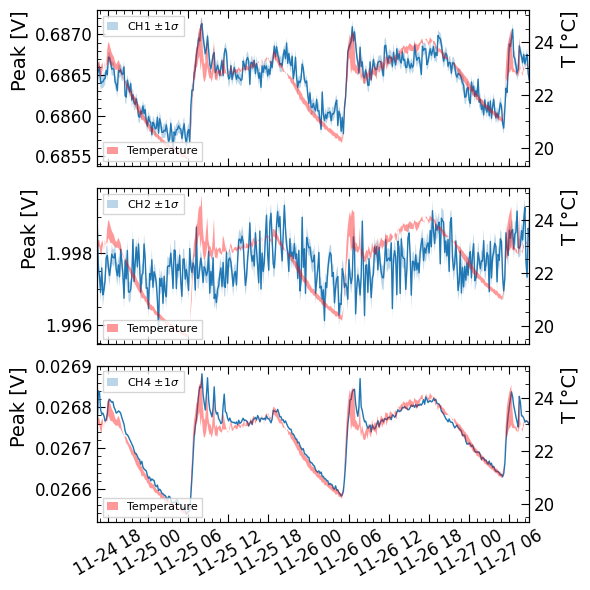

In [8]:
fig, ax = plt.subplots(figsize=(6, 2.*3), nrows=3, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Peak [V]')
ax[0].set_xticklabels([])

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [V]')
ax[1].set_xticklabels([])

# CH3
ax[2].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1)
ax[2].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH4 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2], None, 'Peak [V]')
# ax[2].set_xticklabels([])

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()
fig.savefig(f"../plots/{TIME_RANGE}.png", dpi=300, bbox_inches='tight')

##### Multiple-column plot example

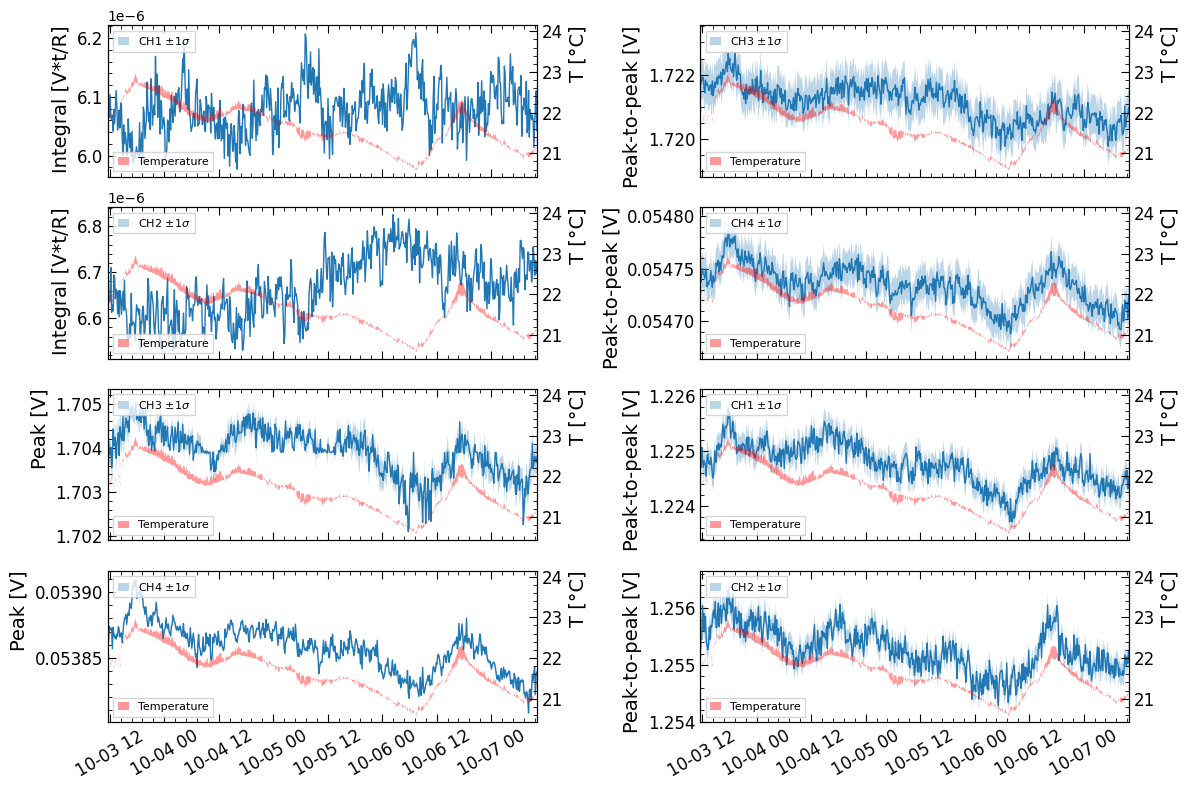

In [11]:
fig, ax = plt.subplots(figsize=(6*2, 2.*4), ncols=2, nrows=4, layout='tight')

# CH1
ax[0, 0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0, 0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0, 0], None, 'Integral [V*t/R]')
ax[0, 0].set_xticklabels([])

# CH2
ax[1, 0].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1, 0].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1, 0], None, 'Integral [V*t/R]')
ax[1, 0].set_xticklabels([])

# CH3
ax[2, 0].plot(Output.Date, Output.Peak_CH3.astype(float), lw=1)
ax[2, 0].fill_between(Output.Date, Output.Peak_CH3-Output.Err_Peak_CH3,  Output.Peak_CH3+Output.Err_Peak_CH3, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2, 0], None, 'Peak [V]')
ax[2, 0].set_xticklabels([])

# CH4
ax[3, 0].plot(Output.Date, Output.Peak_CH4, lw=1)
ax[3, 0].fill_between(Output.Date, Output.Peak_CH4-Output.Err_Peak_CH4,  Output.Peak_CH4+Output.Err_Peak_CH4, alpha=0.3, label='CH4 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[3, 0], None, 'Peak [V]')

# CH5
ax[0, 1].plot(Output.Date, Output.Peak_CH5, lw=1)
ax[0, 1].fill_between(Output.Date, Output.Peak_CH5-Output.Err_Peak_CH5,  Output.Peak_CH5+Output.Err_Peak_CH5, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0, 1], None, 'Peak-to-peak [V]')
ax[0, 1].set_xticklabels([])

# CH6
ax[1, 1].plot(Output.Date, Output.Peak_CH6, lw=1)
ax[1, 1].fill_between(Output.Date, Output.Peak_CH6-Output.Err_Peak_CH6,  Output.Peak_CH6+Output.Err_Peak_CH6, alpha=0.3, label='CH4 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1, 1], None, 'Peak-to-peak [V]')
ax[1, 1].set_xticklabels([])

# CH5
ax[2, 1].plot(Output.Date, Output.Peak_CH7, lw=1)
ax[2, 1].fill_between(Output.Date, Output.Peak_CH7-Output.Err_Peak_CH7,  Output.Peak_CH7+Output.Err_Peak_CH7, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[2, 1], None, 'Peak-to-peak [V]')
ax[2, 1].set_xticklabels([])

# CH5
ax[3, 1].plot(Output.Date, Output.Peak_CH8, lw=1)
ax[3, 1].fill_between(Output.Date, Output.Peak_CH8-Output.Err_Peak_CH8,  Output.Peak_CH8+Output.Err_Peak_CH8, alpha=0.3, label='CH2 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[3, 1], None, 'Peak-to-peak [V]')

for row in ax:
    for a in row:
        # gfx
        a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
        a.tick_params(axis='x', labelrotation=30)
        a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

        # plot temperatures
        a2 = a.twinx()
        a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
        pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
        a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()
fig.savefig(f"../plots/{TIME_RANGE}.png", dpi=300, bbox_inches='tight')

##### Dump analysis outcome to external files

In [11]:
# dump single channels to file
Output[['Date', 'Peak_CH1']].to_csv(
   f'../out/{TIME_RANGE}_Complete_CH1.txt',
   index = False,
   sep = ' ',
   header = ['Date', 'Peak']
)
Output[['Date', 'Peak_CH2']].to_csv(
   f'../out/{TIME_RANGE}_Complete_CH2.txt',
   index = False,
   sep = ' ',
   header = ['Date', 'Peak']
)
Output[['Date', 'Peak_CH3']].to_csv(
   f'../out/{TIME_RANGE}_Complete_CH3.txt',
   index = False,
   sep = ' ',
   header = ['Date', 'Peak']
)

In [13]:
# extract gain
# K = 20.6
# Output['Gain'] = K * (Output['Peak_CH3'] / Output['Peak_CH4'])
# Output['Err_Gain'] = Output['Gain'] * Output['Peak_CH4']

# dump it to file
VarsToDump = ['Peak_CH1', 'Peak_CH2', 'Peak_CH3']
Output[VarsToDump].to_csv(
   f'../out/{TIME_RANGE}_Gain.txt',
   index = False,
   sep = ',',
   header = ['CH1', 'CH2', 'CH3']
)

# dump single channels to file
Output[['Peak_CH1']].to_csv(
   f'../out/{TIME_RANGE}_CH1.txt',
   index = False,
   decimal = ',',
   sep = ' ',
   header = ['CH1']
)
Output[['Peak_CH2']].to_csv(
   f'../out/{TIME_RANGE}_CH2.txt',
   index = False,
   decimal = ',',
   sep = ' ',
   header = ['CH2']
)
Output[['Peak_CH3']].to_csv(
   f'../out/{TIME_RANGE}_CH3.txt',
   index = False,
   decimal = ',',
   sep = ' ',
   header = ['CH3']
)
# Output[['Peak_CH4']].to_csv(
#    f'../out/{TIME_RANGE}_CH4.txt',
#    index = False,
#    decimal = ',',
#    sep = ' ',
#    header = ['CH4']
# )
# Output[['Peak_CH5']].to_csv(
#    f'../out/{TIME_RANGE}_CH5.txt',
#    index = False,
#    decimal = ',',
#    sep = ' ',
#    header = ['CH5']
# )
# Output[['Peak_CH6']].to_csv(
#    f'../out/{TIME_RANGE}_CH6.txt',
#    index = False,
#    decimal = ',',
#    sep = ' ',
#    header = ['CH6']
# )
# Output[['Peak_CH7']].to_csv(
#    f'../out/{TIME_RANGE}_CH7.txt',
#    index = False,
#    decimal = ',',
#    sep = ' ',
#    header = ['CH7']
# )
# Output[['Peak_CH8']].to_csv(
#    f'../out/{TIME_RANGE}_CH8.txt',
#    index = False,
#    decimal = ',',
#    sep = ' ',
#    header = ['CH8']
# )

Output.head()

,Peak_CH1,Err_Peak_CH1,Width_CH1,Err_Width_CH1,Peak_CH2,Err_Peak_CH2,Width_CH2,Err_Width_CH2,Peak_CH3,Err_Peak_CH3,Width_CH3,Err_Width_CH3,Date,Number
8,0.686528,0.000080,0.001669,0.000080,1.998846,0.000436,0.009407,0.000436,0.026762,0.000002,-0.000056,0.000002,2025-11-24 16:23:00,11.0
9,0.686515,0.000089,0.001713,0.000089,1.998758,0.000490,0.009508,0.000490,0.026761,0.000002,-0.000057,0.000002,2025-11-24 16:23:00,10.0
10,0.686551,0.000098,0.001849,0.000098,1.997555,0.000252,0.010144,0.000252,0.026840,0.000002,-0.000055,0.000002,2025-11-24 16:33:00,12.0
11,0.686604,0.000082,0.001728,0.000082,1.997352,0.000247,0.009639,0.000247,0.026836,0.000002,-0.000053,0.000002,2025-11-24 16:43:00,13.0
12,0.686399,0.000079,0.001721,0.000079,1.996909,0.000268,0.009676,0.000268,0.026794,0.000002,-0.000054,0.000002,2025-11-24 16:53:00,14.0


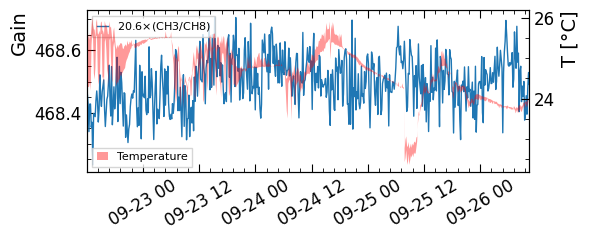

In [10]:
fig, ax = plt.subplots(figsize=(6, 2.5), nrows=1, layout='tight')

# CH1
ax.plot(Output.Date, Output.Gain, lw=1, label='20.6$\\times$(CH3/CH8)')
# ax.fill_between(Output.Date, Output.Gain-Output.Err_Gain,  Output.Gain+Output.Err_Gain, alpha=0.3, label='20.6$\\times$(CH3/CH8) $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax, None, 'Gain')

# gfx
ax.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
ax.tick_params(axis='x', labelrotation=30)
ax.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

# plot temperatures
a2 = ax.twinx()
a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()
fig.savefig(f"../plots/{TIME_RANGE}_Gain.png", dpi=300, bbox_inches='tight')

#### Merge all campaigns

This needs more work, to account for the fact that channels have different meanings in different measurement campaigns.

In [8]:
PATH_DATA = "../data"

In [10]:
# analyze all campaigns together
Output, Temperatures = pmana.utils.anatestdata.MergeCampaigns(
    PATH_DATA,                                      ###< top path to restructured data
    pmana.utils.io.ExtractFileTimes,                ###< analyzer to handle time mapping
    pmana.utils.io.ExtractTemperatureMonitoring,    ###< analyzer to handle temperatures
    pmana.utils.anatestdata.Iterate,                ###< main loop to each campaign
    pmana.utils.anatestdata.GaussianFitToChannel    ###< analyzer to each measurement
)

# format the output nicely
Output = pandas.DataFrame(Output)
Output.columns = ["Peak_CH1", "Err_Peak_CH1", "Width_CH1", "Err_Width_CH1",
                  "Peak_CH2", "Err_Peak_CH2", "Width_CH2", "Err_Width_CH2", 
                  "Peak_CH3", "Err_Peak_CH3", "Width_CH3", "Err_Width_CH3", 
                  "Peak_CH4", "Err_Peak_CH4", "Width_CH4", "Err_Width_CH4", 
                  "Peak_CH5", "Err_Peak_CH5", "Width_CH5", "Err_Width_CH5", 
                  "Peak_CH6", "Err_Peak_CH6", "Width_CH6", "Err_Width_CH6", 
                  "Peak_CH7", "Err_Peak_CH7", "Width_CH7", "Err_Width_CH7", 
                  "Peak_CH8", "Err_Peak_CH8", "Width_CH8", "Err_Width_CH8", 
                  "Date", "Number"]
Output.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

# format the temperatures nicely
Temperatures.sort_values(
    by = 'Date', 
    inplace = True,
    ignore_index = True
)

Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00009
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00000
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00007
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00096
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00091
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00065
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00006
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00001
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00251
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00258
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00099
Could not perform fit here:  ../data/20251013/DataPadova_20251013_20251017/00118
Could not perform fit here: 

/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(
/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(
/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(
/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(
/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, covs = scipy.optimize.curve_fit(
/Users/triozzi/Analysis/pmana/pmana/utils/anatestdata.py:114: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, c

Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00031
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00009
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00007
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00053
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00054
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00065
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00008
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00030
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00063
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00052
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00294
Could not perform fit here:  ../data/20250902/DataPadova_20250902_20250905/00142
Could not perform fit here: 

In [11]:
Output

,Peak_CH1,Err_Peak_CH1,Width_CH1,Err_Width_CH1,Peak_CH2,Err_Peak_CH2,Width_CH2,Err_Width_CH2,Peak_CH3,Err_Peak_CH3,...,Peak_CH7,Err_Peak_CH7,Width_CH7,Err_Width_CH7,Peak_CH8,Err_Peak_CH8,Width_CH8,Err_Width_CH8,Date,Number
0,0.000006,2.189572e-09,7.189946e-08,2.193380e-09,0.000007,2.439051e-09,8.163847e-08,2.453461e-09,1.704052,0.000292,...,1.224853,0.000207,0.001894,0.000207,1.255076,0.000239,0.002194,0.000239,2025-10-03 11:34:00,277.0
1,0.000006,1.789126e-09,6.919779e-08,1.789126e-09,0.000007,1.761001e-09,7.284858e-08,1.761001e-09,1.704078,0.000334,...,1.22475,0.000237,0.002072,0.000237,1.255190,0.000230,0.002209,0.000230,2025-10-03 11:35:00,278.0
2,0.000006,1.404540e-09,7.042559e-08,1.404540e-09,0.000007,1.545638e-09,8.186555e-08,1.545638e-09,1.704095,0.000187,...,1.224697,0.000223,0.001950,0.000223,1.255482,0.000194,0.002123,0.000194,2025-10-03 11:44:00,279.0
3,0.000006,1.898582e-09,7.596995e-08,1.898582e-09,0.000007,2.183168e-09,8.126290e-08,2.183168e-09,1.703918,0.000314,...,1.225069,0.000237,0.001980,0.000237,1.255450,0.000198,0.002219,0.000198,2025-10-03 11:54:00,280.0
4,0.000006,1.547816e-09,7.076289e-08,1.547816e-09,0.000007,2.416638e-09,8.292169e-08,2.416638e-09,1.703844,0.000292,...,1.224842,0.000235,0.001940,0.000235,1.256043,0.000192,0.002148,0.000192,2025-10-03 12:04:00,281.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8082,0.000007,1.482563e-09,5.965642e-08,1.482950e-09,0.955324,1.314215e-04,2.256917e-03,1.314222e-04,2025-07-23 10:49:00,278.000000,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
8083,0.000007,1.765055e-09,6.152427e-08,1.765631e-09,0.958199,1.391510e-04,2.458493e-03,1.409340e-04,2025-07-23 05:39:00,247.000000,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
8084,0.000007,1.264976e-09,5.483082e-08,1.265009e-09,0.957666,1.634874e-04,2.639756e-03,1.653122e-04,2025-07-22 00:59:00,75.000000,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
8085,0.000007,1.265554e-09,5.527681e-08,1.265562e-09,0.955447,1.435517e-04,2.453828e-03,1.435599e-04,2025-07-24 08:59:00,411.000000,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


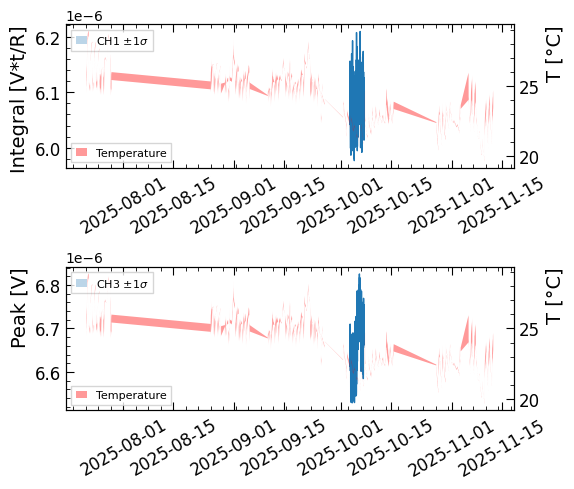

In [13]:
fig, ax = plt.subplots(figsize=(6, 2.5*2), nrows=2, layout='tight')

# CH1
ax[0].plot(Output.Date, Output.Peak_CH1, lw=1)
ax[0].fill_between(Output.Date, Output.Peak_CH1-Output.Err_Peak_CH1,  Output.Peak_CH1+Output.Err_Peak_CH1, alpha=0.3, label='CH1 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[0], None, 'Integral [V*t/R]')

# CH2
ax[1].plot(Output.Date, Output.Peak_CH2, lw=1)
ax[1].fill_between(Output.Date, Output.Peak_CH2-Output.Err_Peak_CH2,  Output.Peak_CH2+Output.Err_Peak_CH2, alpha=0.3, label='CH3 $\\pm1\\sigma$')
pmana.utils.plotting.UpdateMatplotlibStyle(ax[1], None, 'Peak [V]')

for a in ax:
    # gfx
    a.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='upper left')
    a.tick_params(axis='x', labelrotation=30)
    # a.set_xlim(Output['Date'].iloc[0], Output['Date'].iloc[-1])

    # plot temperatures
    a2 = a.twinx()
    a2.fill_between(Temperatures.Date, y1=Temperatures.T1, y2=Temperatures.T2, fc='red', alpha=0.4, label='Temperature', zorder=-3)
    pmana.utils.plotting.UpdateMatplotlibStyle(a2, None, 'T [°C]')
    a2.legend(frameon=True, fancybox=False, handlelength=1, fontsize=8, loc='lower left')

plt.show()